## Basics

In [3]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

In [4]:
import torch

# Tranferability  Matrix for random subgraphs

In [5]:
## Old Code
#@title
from matplotlib import pyplot
from matplotlib import gridspec

def get_qaoa_params(graph, edge=None, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

def transferability_matrix(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matrix_loss = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            print('donor loss ' + str(loss))
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                print('acceptor loss' + str(trloss))
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2 + 0.001)
                matrix_loss[i,j] += similarity
    return matrix_loss


def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

In [6]:
## My Code
def get_qaoa_params(graph, edge=None, gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

In [13]:
def subgraph_optimal_param_and_cost(graph, edge, p, seeds, steps):
  '''
  Optimize parameters of a subgraph, do so (seed) many times with random initial
  ized parameters

  Return: array of Results of (seed) many optimization runs and the index of 
  array corresponding to max energy
  '''
  results = []
  s = 0 #iterator
  max_energy = -1
  max_index = 0

  while s<seeds:
    gamma = [np.random.rand() for i in range(p)]
    beta = [np.random.rand() for i in range(p)]
    params, loss = get_qaoa_params(graph, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
    gamma_opt, beta_opt = params[0], params[1]
    energy = (1-loss)/2
    result = [gamma_opt, beta_opt, energy]
    results.append(result)

    # comparing with max
    if energy >max_energy:
      max_index = s
      max_energy = energy
    s+=1
    
  max_result = results[max_index]
  return max_result

In [16]:
def mod_transferability_matrix_new(graphs, p=1, seeds = 20, steps = 200):
    '''
    Returns a len(graph) x len(graph) matrix with tranferability coefficients 
    between all possible pairs of graphs
    '''
    #Optimization runs for every graph
    graph_optimization = []
    iterr = 0
    for g in graphs:
        iterr +=1
        print(iterr)
        results = subgraph_optimal_param_and_cost(graph = g, edge = (0,1), p = p, seeds = seeds, steps = steps)
        graph_optimization.append(results)
  
    #create the transferability matrix
    matrix = np.zeros((len(graphs), len(graphs)))
    print(graph_optimization)

    for i, donor in enumerate(graphs):
        donor_result = graph_optimization[i]

        for j, acceptor in enumerate(graphs):
            #acceptors max energy first
            acc_energy = graph_optimization[j][2]
            donor_gamma = donor_result[0]
            donor_beta = donor_result[1]
            trans_loss = get_edge_contribution(acceptor, (0,1), donor_gamma, donor_beta)
            trans_energy = (1-trans_loss)/2
            # print('donors is : ' + str(i))
            # print('acceptor is : ' + str(j))
            # print('trans energy is: ' + str(trans_energy))
            # print('max energy of acceptor is : ' + str(acc_energy))
            matrix[i,j] += trans_energy/acc_energy
    return matrix


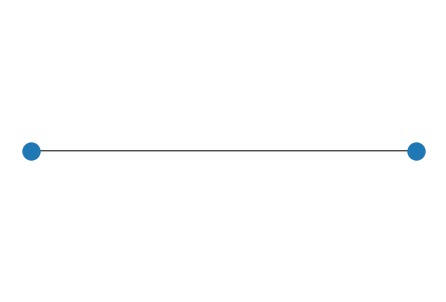

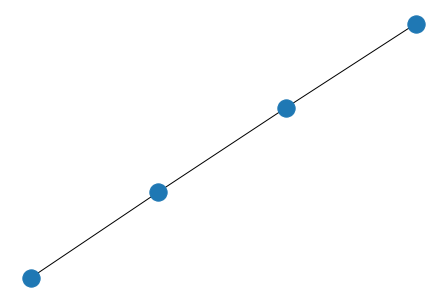

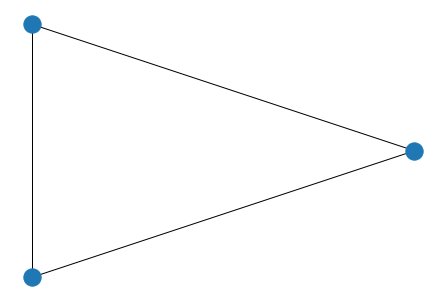

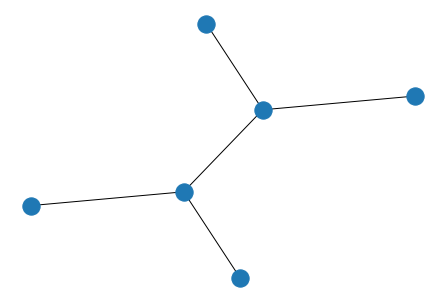

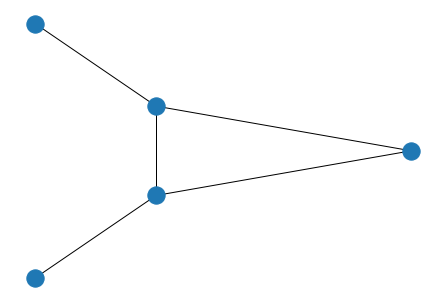

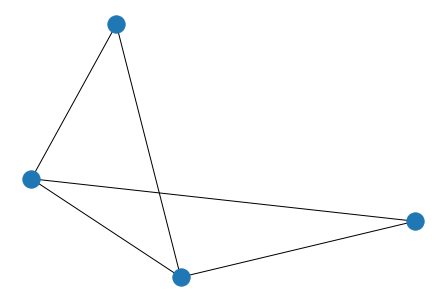

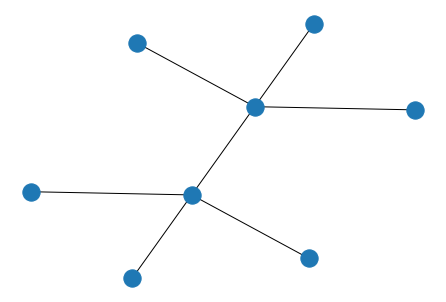

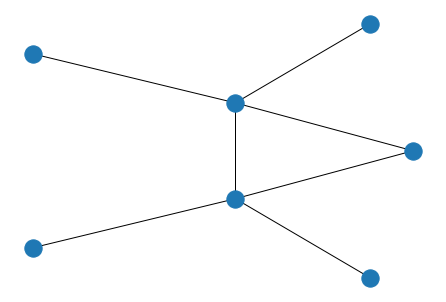

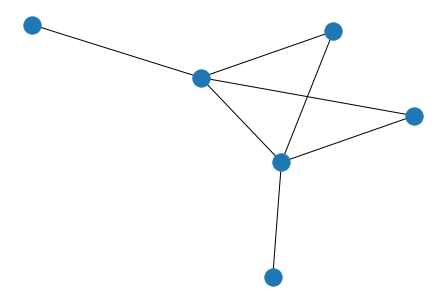

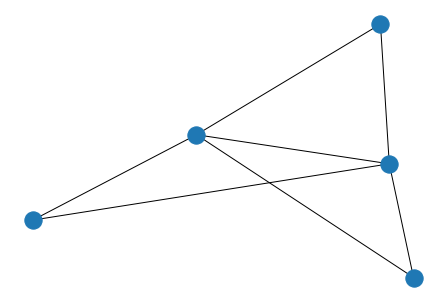

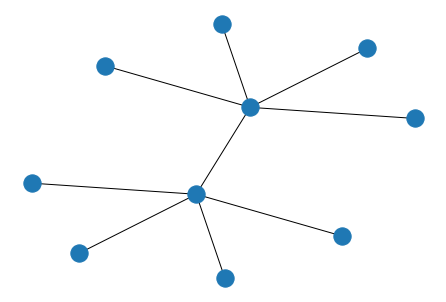

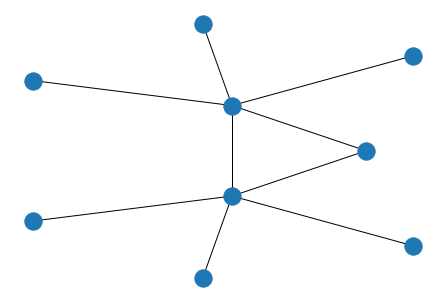

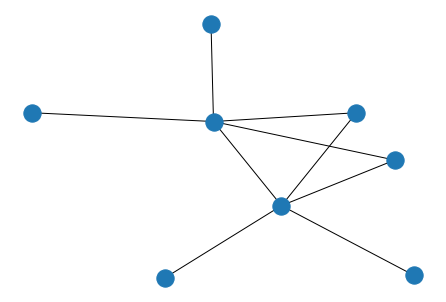

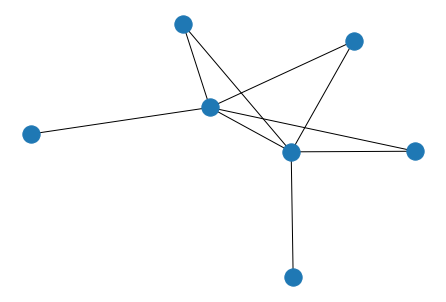

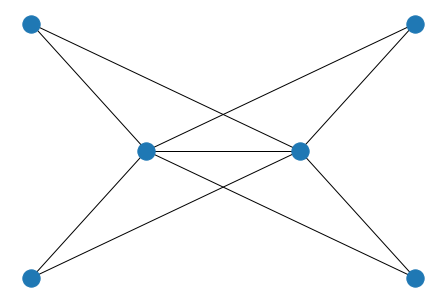

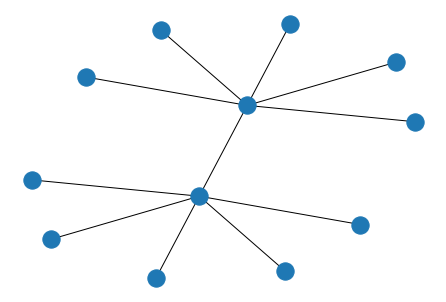

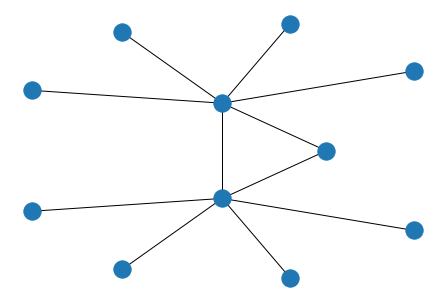

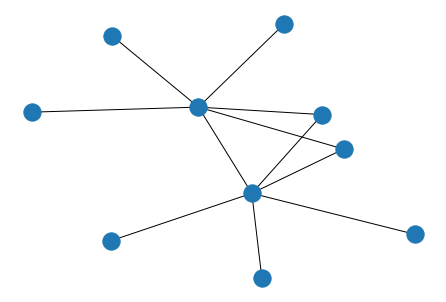

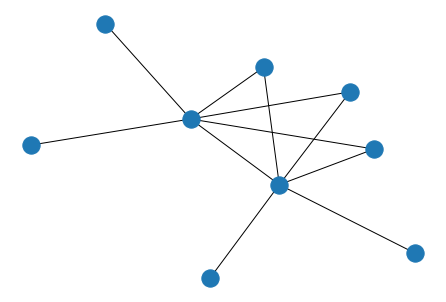

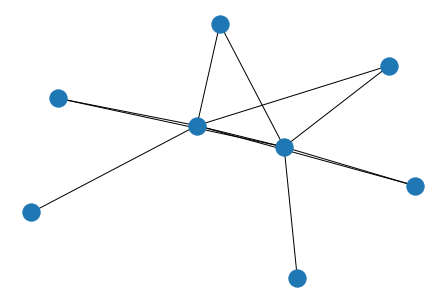

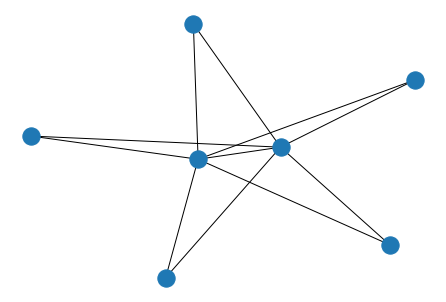

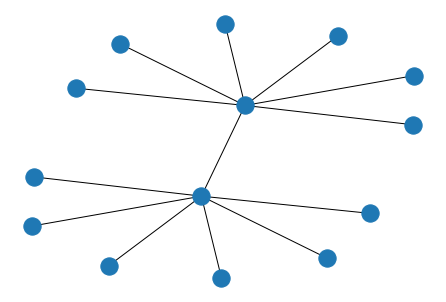

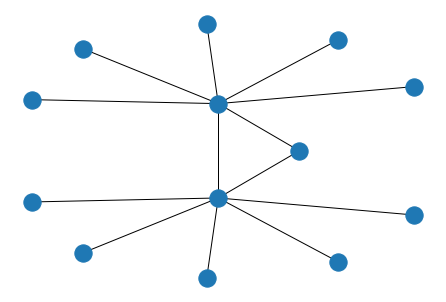

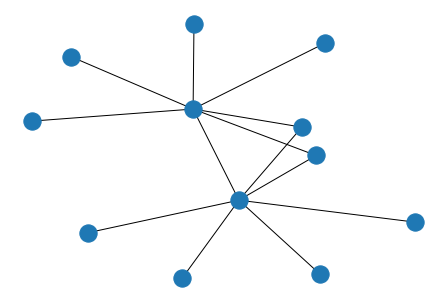

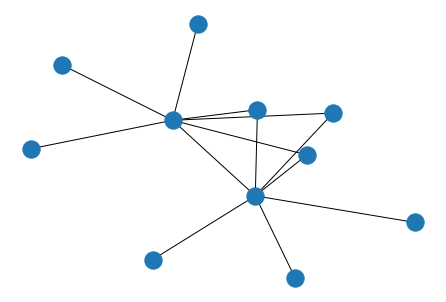

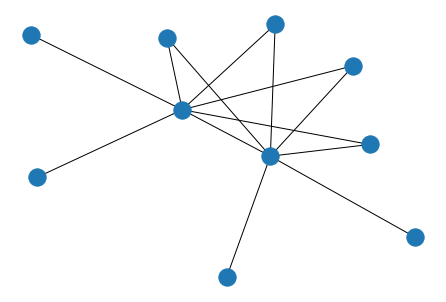

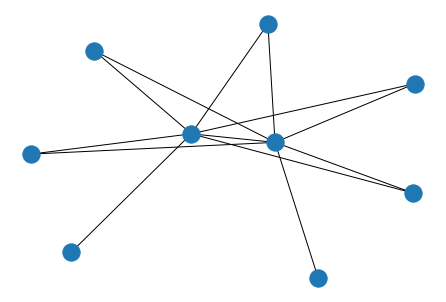

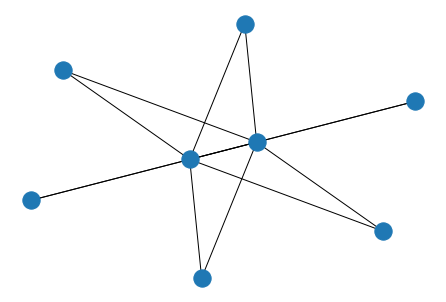

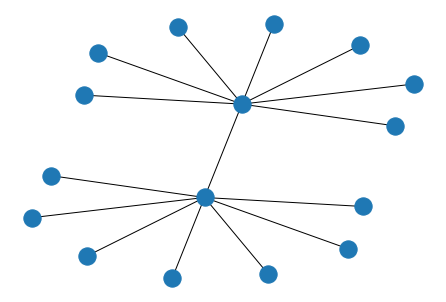

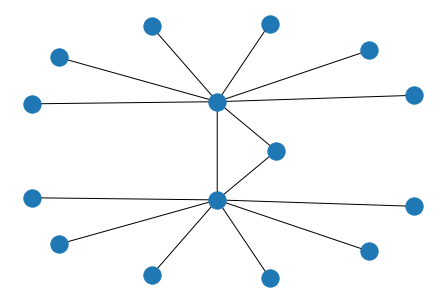

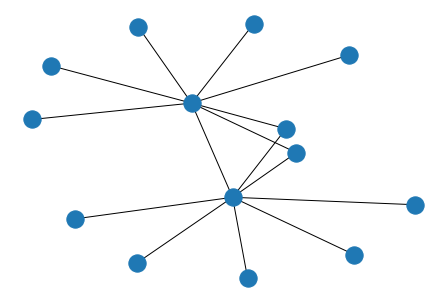

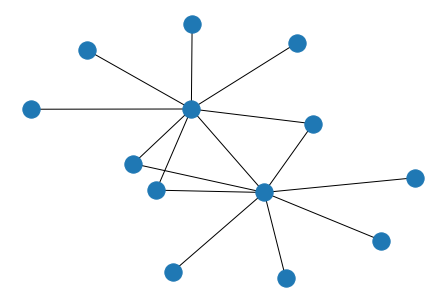

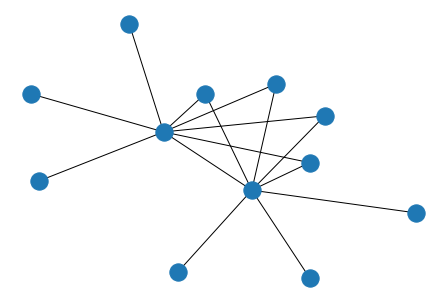

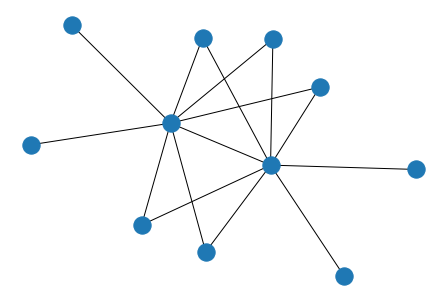

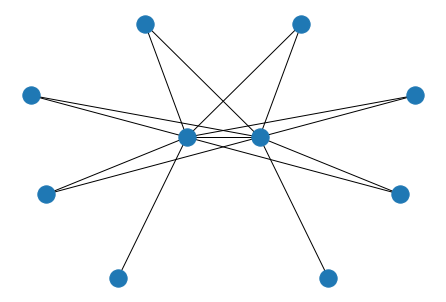

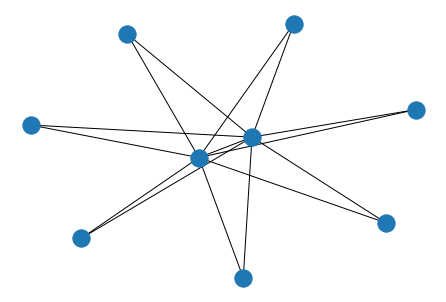

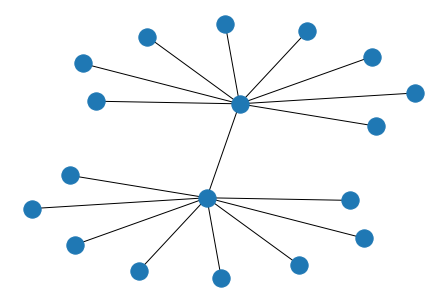

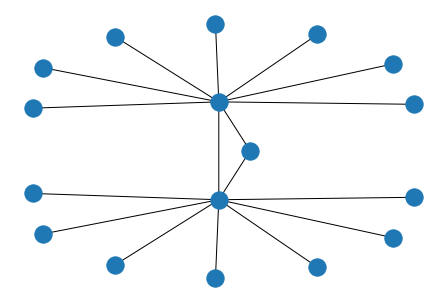

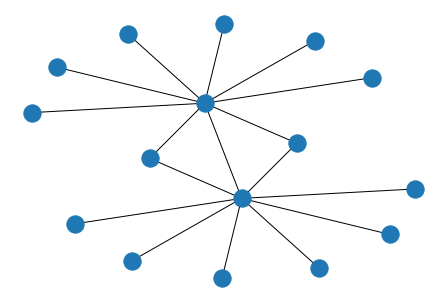

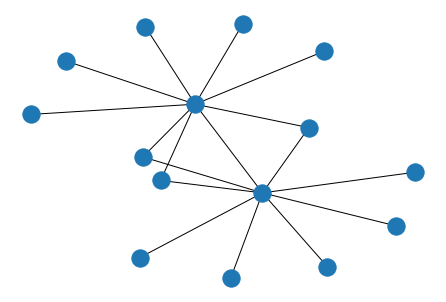

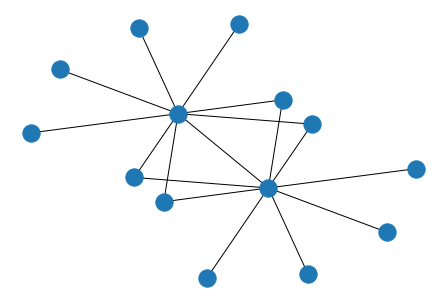

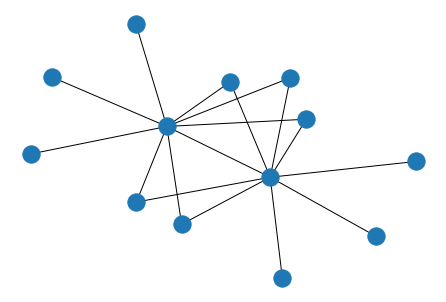

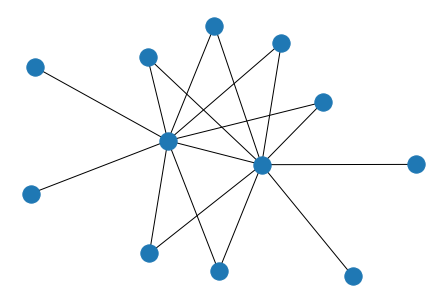

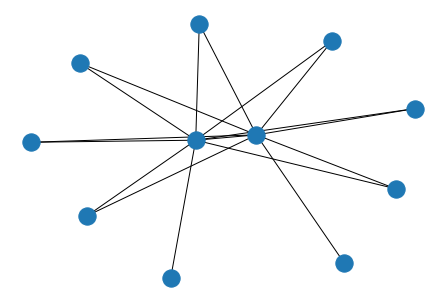

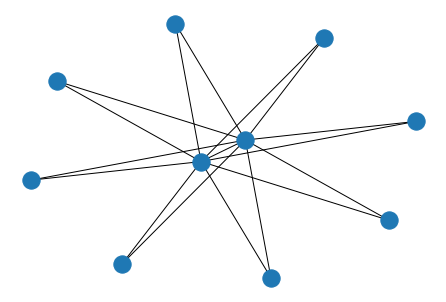

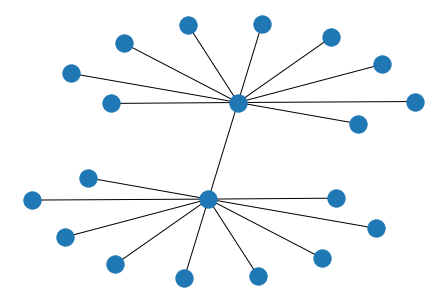

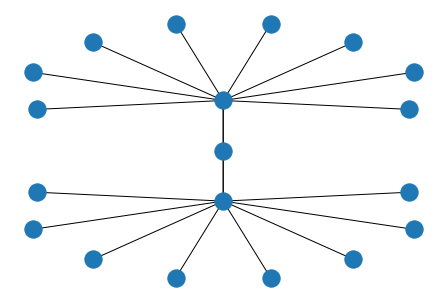

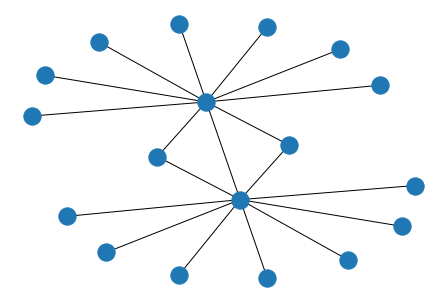

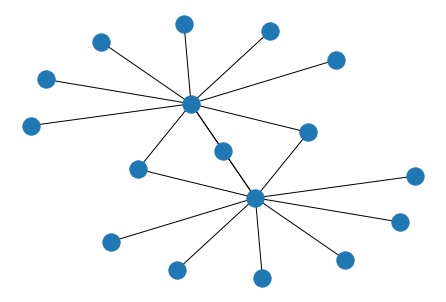

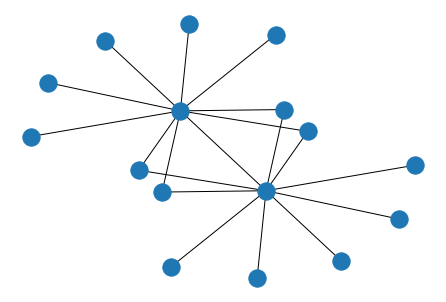

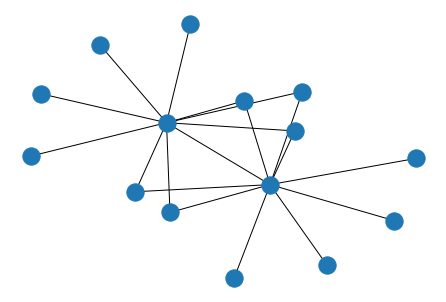

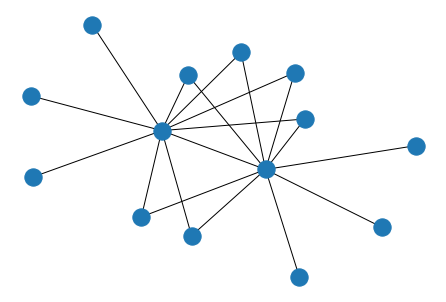

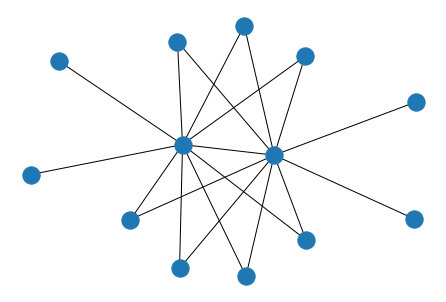

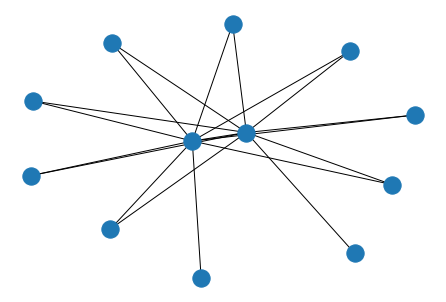

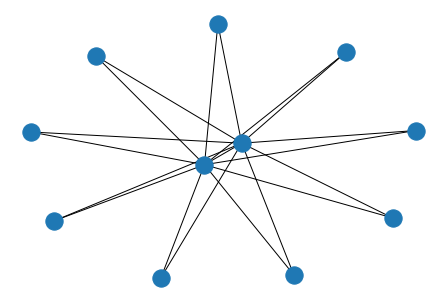

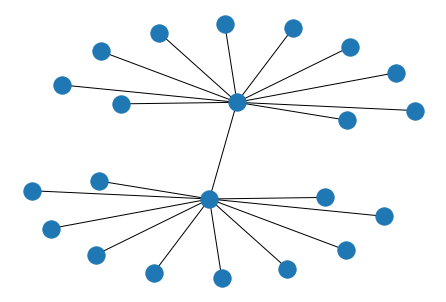

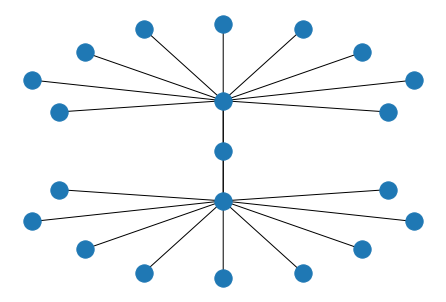

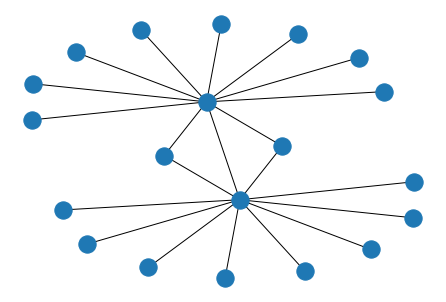

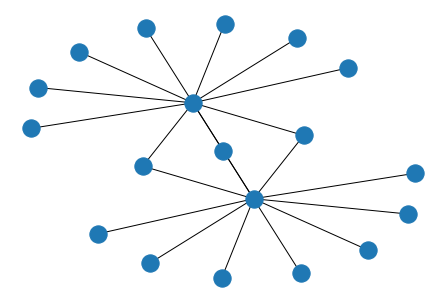

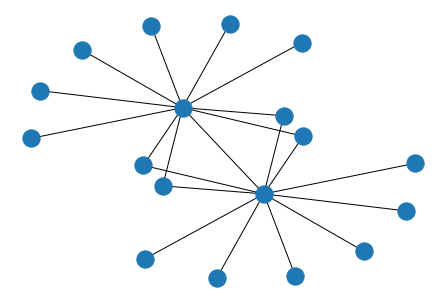

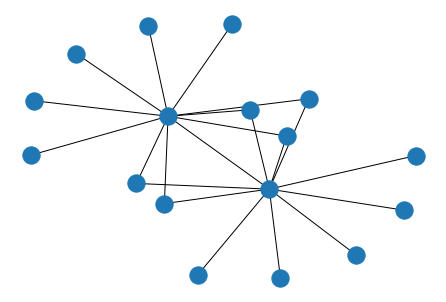

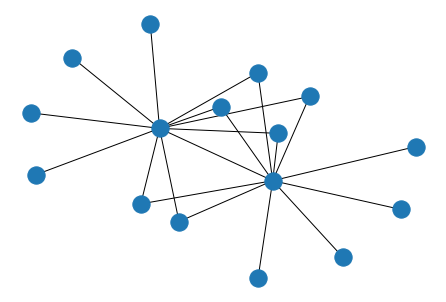

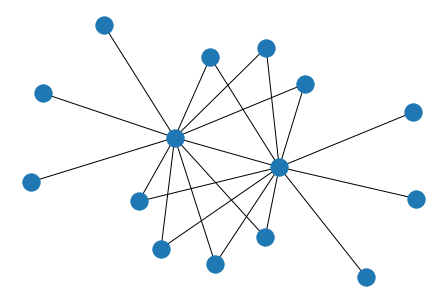

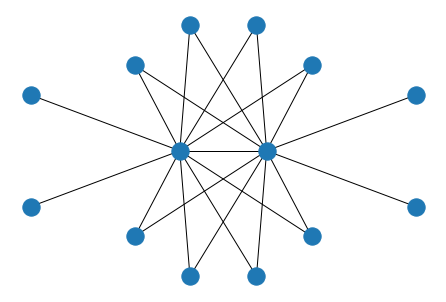

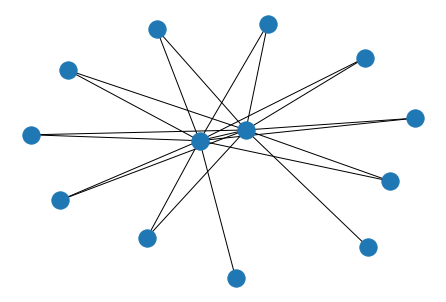

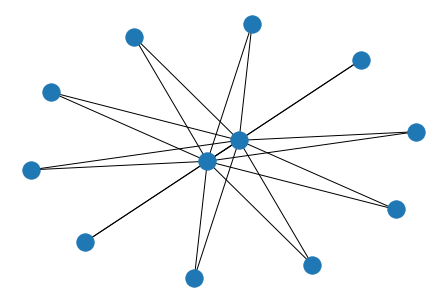

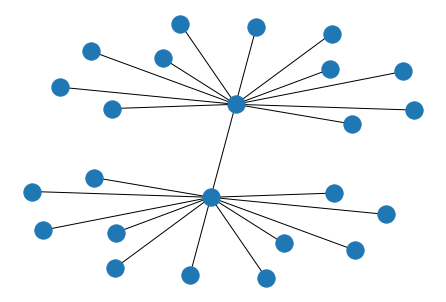

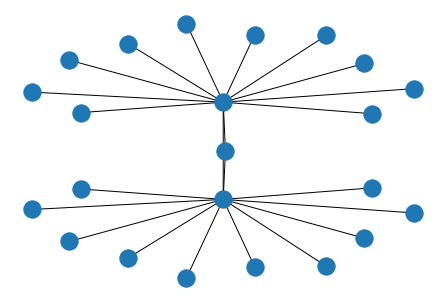

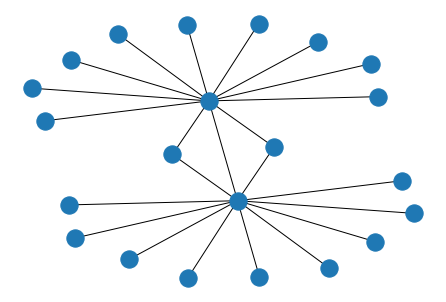

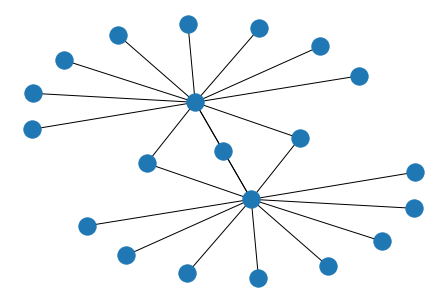

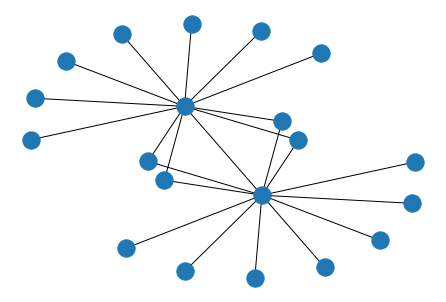

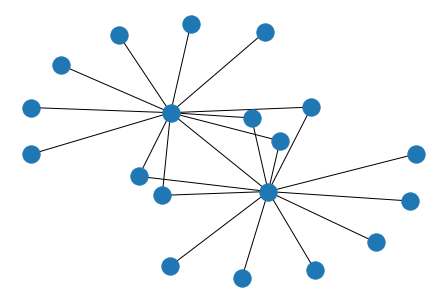

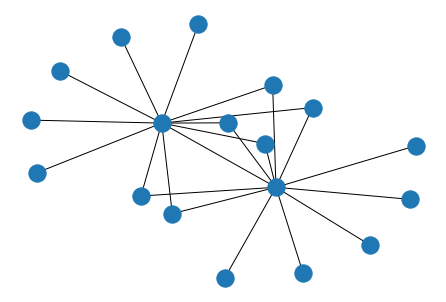

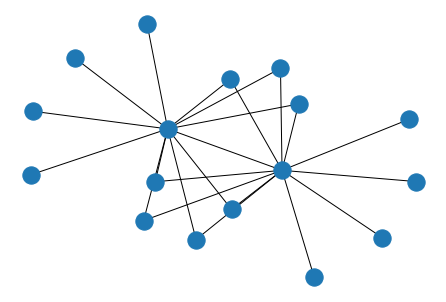

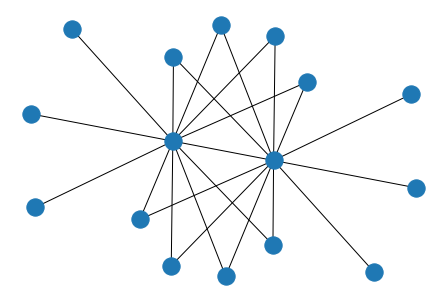

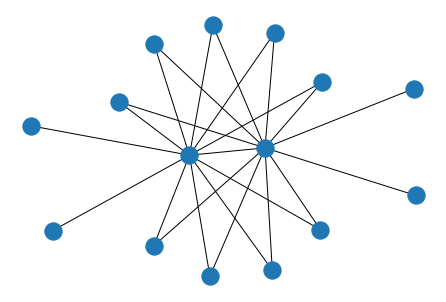

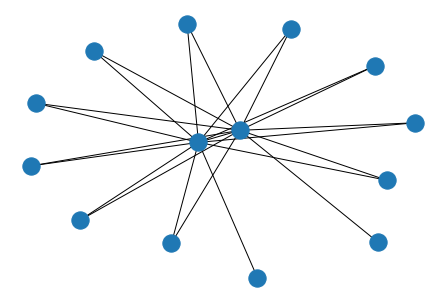

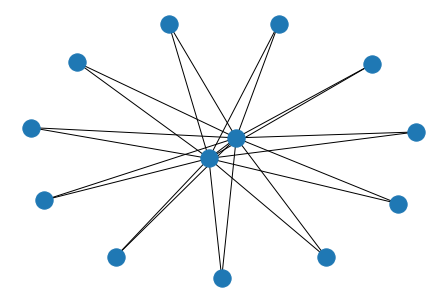

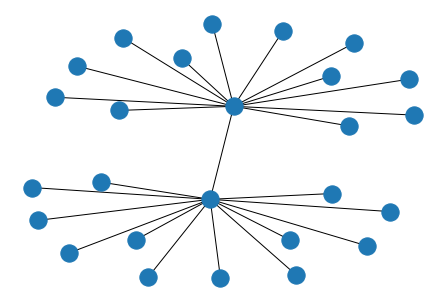

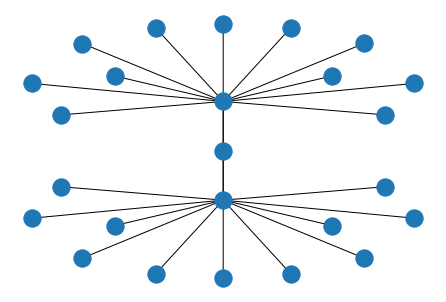

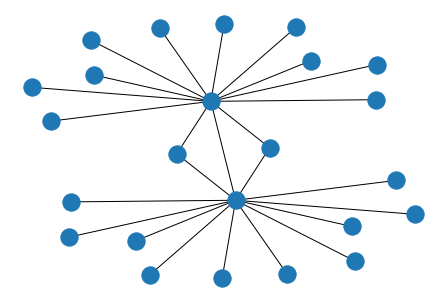

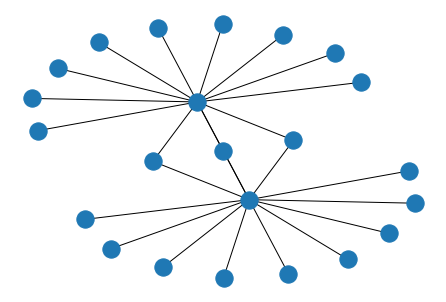

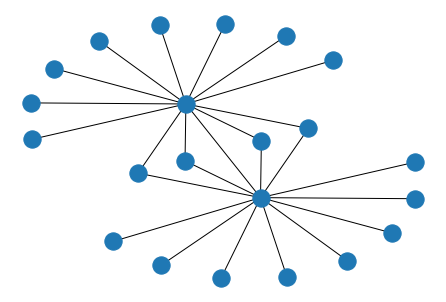

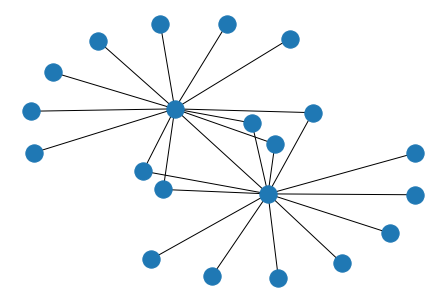

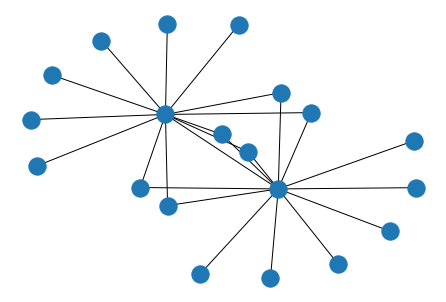

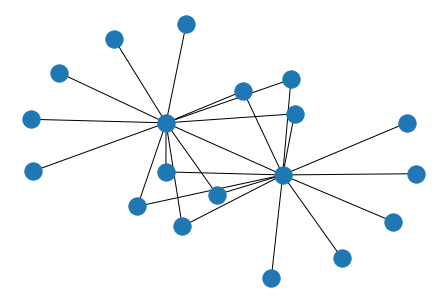

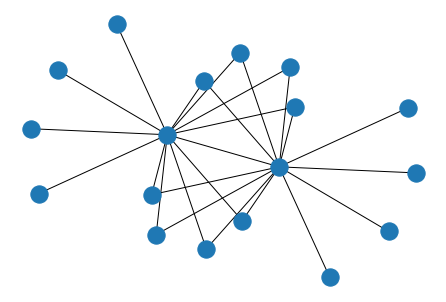

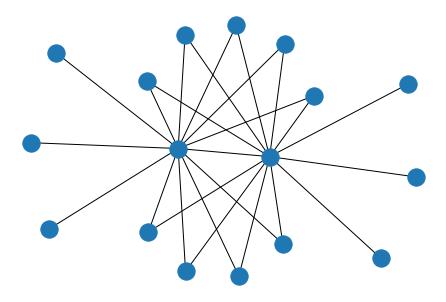

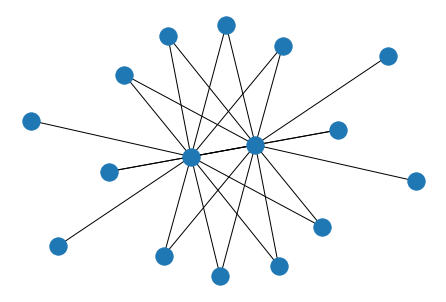

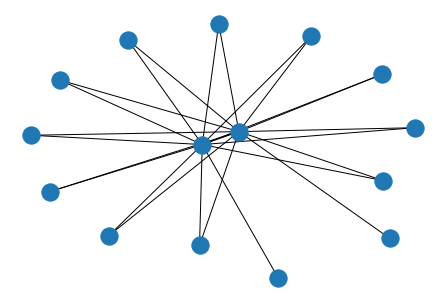

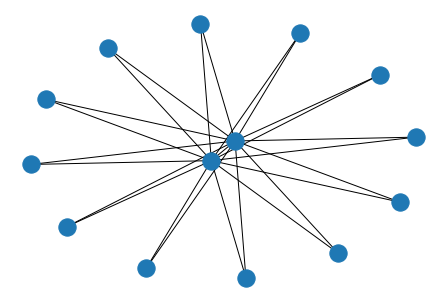

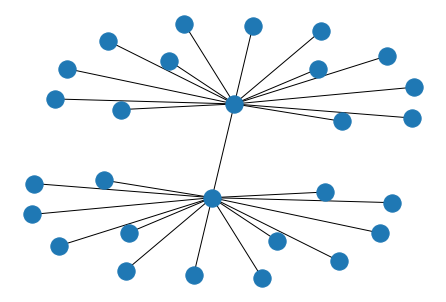

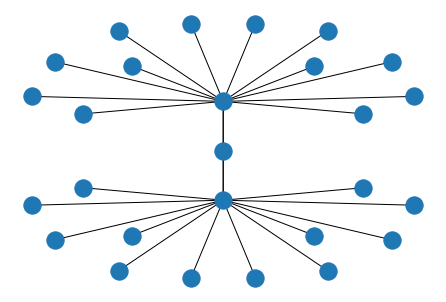

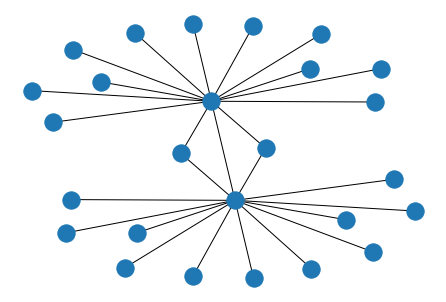

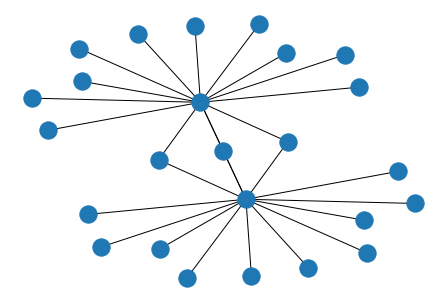

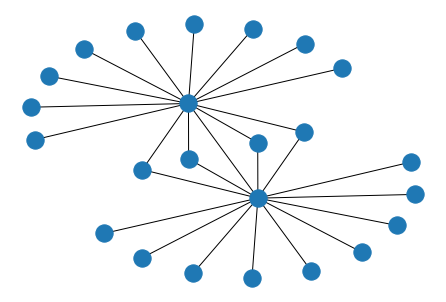

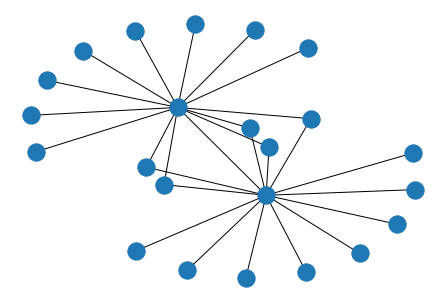

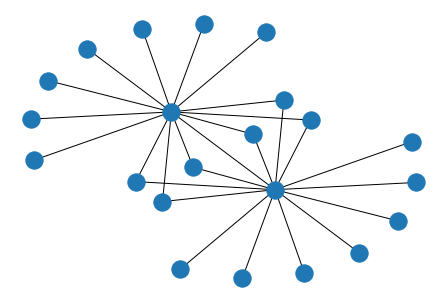

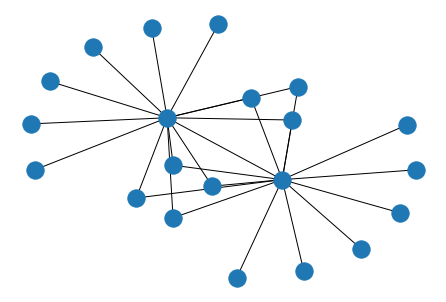

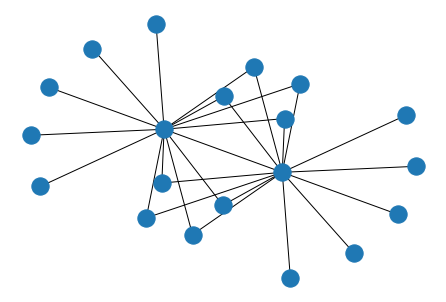

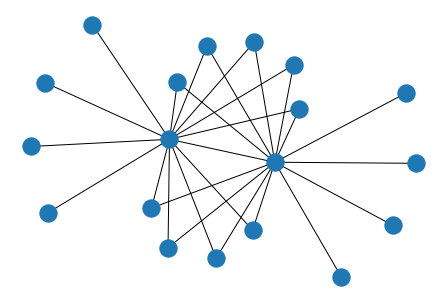

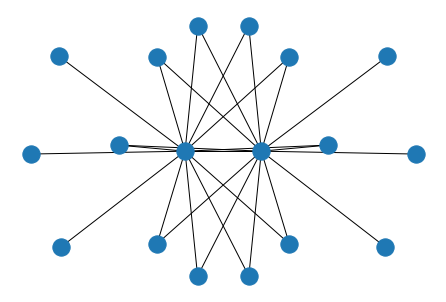

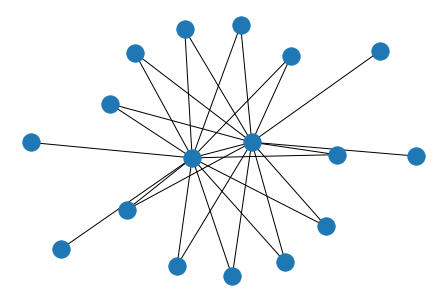

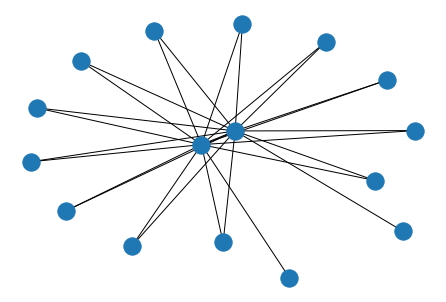

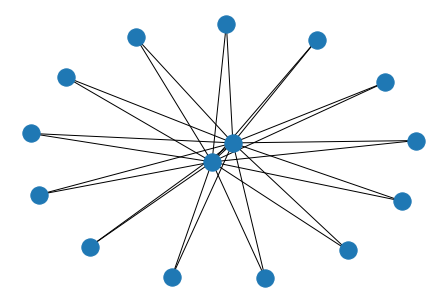

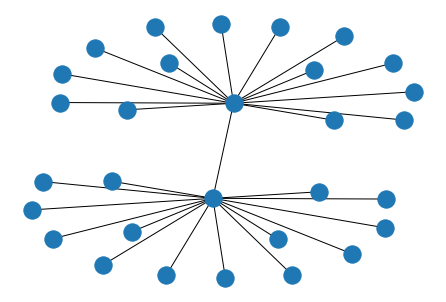

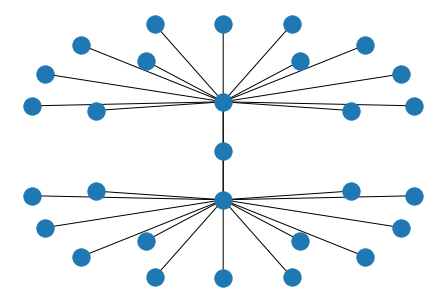

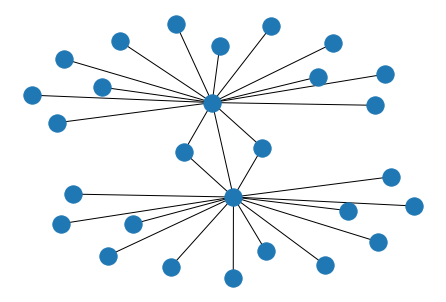

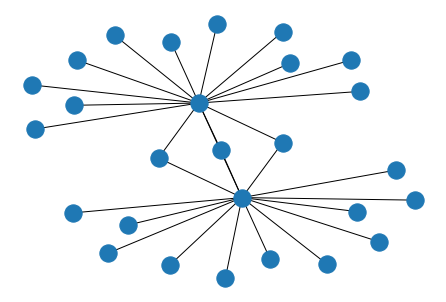

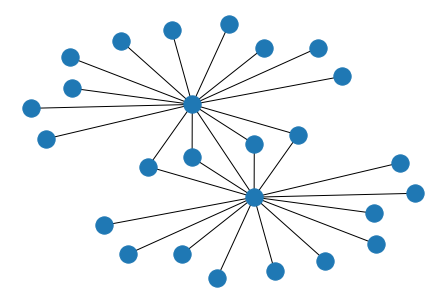

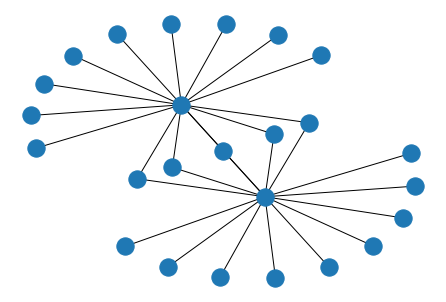

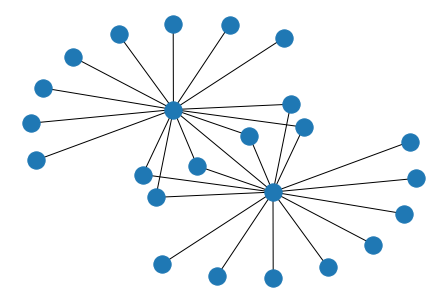

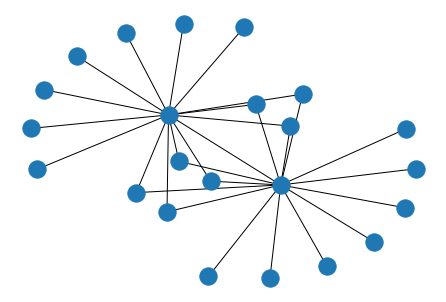

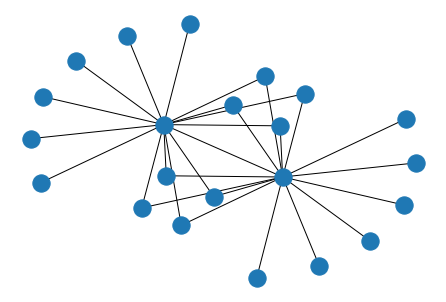

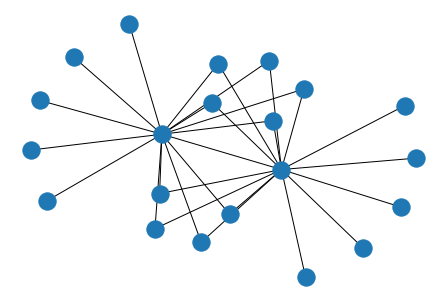

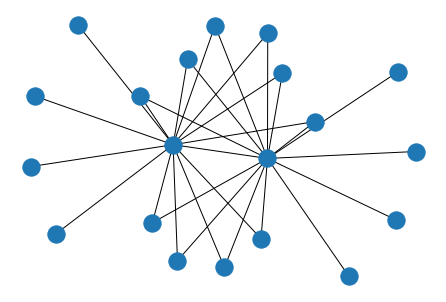

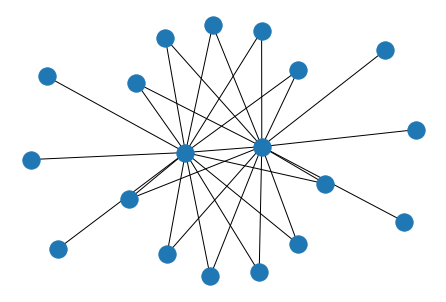

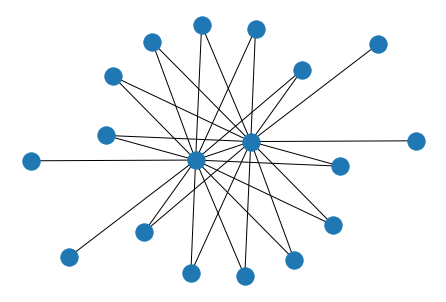

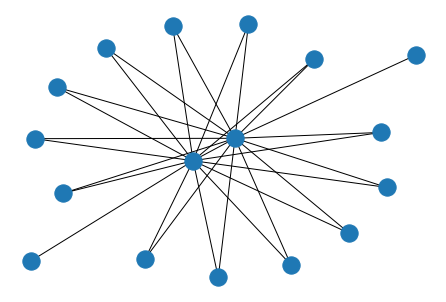

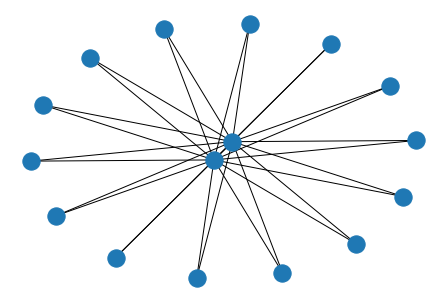

In [9]:
#generating all subgraphs first 
g_all = []
indexes = [] #for numbering later
d = 1
dmax = 15
step = 1
while d<= dmax:
  g_subs = sub_all(d, d, True)
  indexes += [d for i in range(len(g_subs))]
  g_all += g_subs
  d+=step

In [8]:
len(g_all)

120

In [19]:
tranf_mat = mod_transferability_matrix_new(g_all, seeds = 20)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
[[array([0.7500003], dtype=float32), array([1.1249996], dtype=float32), 1.0000001788139343], [array([0.625], dtype=float32), array([-0.12499414], dtype=float32), 0.7500000894069672], [array([0.09797067], dtype=float32), array([0.4020558], dtype=float32), 0.6666667312383652], [array([0.9020315], dtype=float32), array([0.62500685], dtype=float32), 0.6924501210451126], [array([0.58733815], dtype=float32), array([0.10469727], dtype=float32), 0.6466836184263229], [array([0.42177284], dtype=float32), array([0.91009873], dtype=float32), 0.6162528321146965], [array([0.5833338], dtype=float32), array([-0.12499999], dtype=float32)

In [20]:
a_file = open("mod_transferability_matrix_regular_subgraphs_1_15.txt", "w")
for row in tranf_mat:
    np.savetxt(a_file, row)
a_file.close()

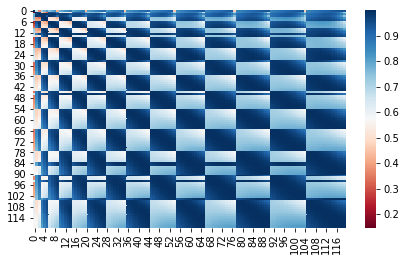

In [26]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
plt.figure(figsize = (7,4))

# Index= labels
# Cols = labels
df = DataFrame(tranf_mat)  #, index=Index, columns=Cols)
# plt.vlines(grid_lines, 0, n)
# plt.hlines(grid_lines, 0, n)

sns.heatmap(df, annot=False, cmap="RdBu")
plt.show()